<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/mFSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Implement Pawel Penczek's mFSR

# Resources
Penczek, P. A. (2020). Reliable cryo-EM resolution estimation with modified Fourier shell correlation. IUCrJ, 7(6), 1–14. http://doi.org/10.1107/s2052252520011574

Henning, A. J., Huntley, J. M., & Giusca, C. L. (2015). Obtaining the Transfer Function of optical instruments using large calibrated reference objects. Optics Express, 23(13), 16617. http://doi.org/10.1364/OE.23.016617

# Setup

In [1]:
%%bash
pip install pyFFTW

In [90]:
%%bash
cd
rm twod.py
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py

rm fourier.py
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/fourier.py
#wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/fourier.py

rm mrc.py
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py


--2020-10-02 20:58:03--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14698 (14K) [text/plain]
Saving to: ‘twod.py’

     0K .......... ....                                       100% 1.40M=0.01s

2020-10-02 20:58:03 (1.40 MB/s) - ‘twod.py’ saved [14698/14698]

--2020-10-02 20:58:03--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [91]:
%cd

import numpy as np
import pandas as pd
import mrc
import importlib


try:
  del twod
except:
  pass
%rm -r __pycache__/
import twod
importlib.reload(twod)

try:
  del fourier
except:
  pass
%rm -r __pycache__/
import fourier
importlib.reload(fourier)


import matplotlib.pyplot as plt
import collections
import scipy.ndimage

/root


# Image

In [ ]:
%%bash
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-7981/map/emd_7981.map.gz
gunzip emd_7981.map.gz


In [5]:
fname = 'emd_7981.map'#'/content/drive/My Drive/repos/learn_cryoem_math/data/ouhn_Data1_P1/emd_9243_downsample_64pix.mrc'#emd_9243_downsample_128pix_lp3A.mrc.mrc'#'emd_9243.map'
vol = mrc.read(fname)
nx = vol.shape[0]
psize_A = 1.088 #3.9375

In [6]:
nx = vol.shape[0]

## coordinates

In [19]:
def make_coordinates (N,d,reshape=False):
  '''
  make list of d dimensional points. each row is the coordinates of the point
  N**d rows, d columns
  '''
  x = np.arange(-N/2,N/2,dtype=np.float32)
  c = x.copy()
  for i in range(1,d):
      c = np.column_stack([np.tile(x, N**i), np.repeat(c, N, axis=0)])
  return c

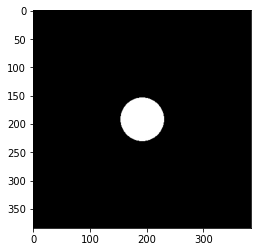

In [24]:
sphere = np.linalg.norm(make_coordinates(nx,3),axis=1).reshape(nx,nx,nx) 
mask_sphere = sphere < .1*nx
twod.do_2dplot(mask_sphere[nx//2,:,:])

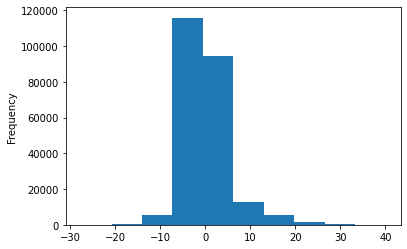

In [25]:
pd.Series(vol[mask_sphere]).plot.hist()

In [26]:
sigma = 1
noise = np.random.normal(scale=sigma*np.ones_like(vol))

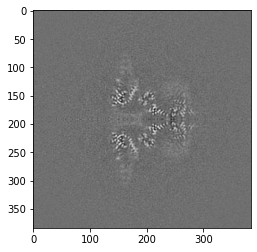

In [27]:
twod.do_2dplot(vol[nx//2,:,:])

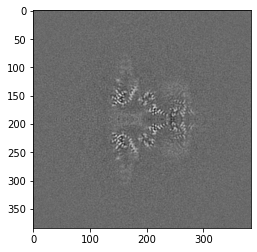

In [52]:
twod.do_2dplot((vol+noise)[nx//2,:,:])

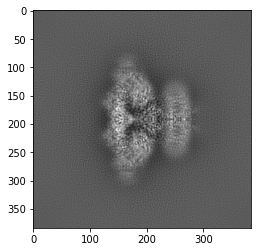

In [116]:
twod.do_2dplot((vol).mean(0))

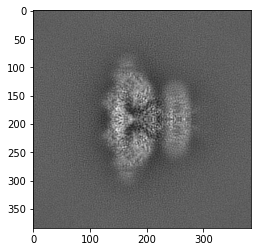

In [54]:
twod.do_2dplot((vol+noise).mean(0))

## half maps

In [82]:
def make_scale_factor(N):
  nsig = 128
  d=3
  x = np.arange(-7*nsig/2, 7*nsig/2)/float(nsig) # [-7/2,7/2) in nsig*7 steps
  upfactor = N
  Nsig = int(nsig*upfactor)
  lin_kern = np.maximum(0.0, 1 - np.abs(x)) # triangle impulse
  y =  lin_kern.astype(np.float32)
  x = (np.arange(Nsig) - Nsig/2)/float(upfactor) # [-N,N) in nsig*N steps
  sig = np.zeros(Nsig, dtype=np.float32)
  sig[Nsig//2-7*nsig//2:Nsig//2+7*nsig//2] = y # linear kernel at centre, surrounded by zeros
  fsig = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig))) # FT of triangle -> sinc squared (purely real, imag part from numerical error) http://www.thefouriertransform.com/pairs/triangle.php
  sf = (fsig.real/nsig)[(x>=-0.5) * (x < 0.5)] # take mid part close to origin, ie top part of sinc
  sf = sf.astype(np.float32)
  sf = sf.reshape(N,1,1) * sf.reshape(1,N,1) * sf.reshape(1,1,N) # 1D symmetric to 3D
  return(sf)

sf = make_scale_factor(N)


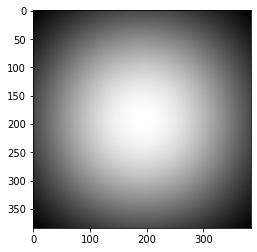

In [40]:
plt.imshow(sf[nx//2],cmap='gray')

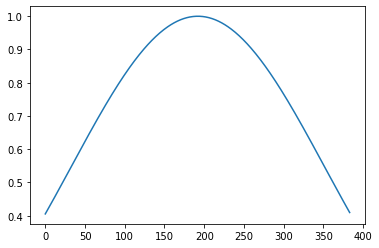

In [83]:
pd.Series(sf[nx//2,nx//2]).plot()

This scale factor is used to multiplicatively scale the real space map before taking the fft. In effect, it's a kind of mask

In [96]:
sf = make_scale_factor(N)
v_f = fourier.do_fft(vol*sf)

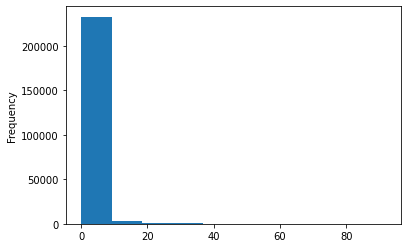

In [97]:
pd.Series(np.abs(v_f[mask_sphere])).plot.hist()

In [ ]:
sigma=1
n1 = np.random.normal(scale=sigma*np.ones_like(vol))
n2 = np.random.normal(scale=sigma*np.ones_like(vol))
m1 = vol + n1
m2 = vol + n2

v_f1 = fourier.do_fft(m1*sf)
v_f2 = fourier.do_fft(m2*sf)


## FSC

In [99]:
def comp_fsc(v_f1,v_f2,rad_width=1):
  '''
  TODO: speed ups by precomputing mask shells
  '''
  nx = v_f1.shape[0]
  m1m2 = np.multiply(v_f1,v_f2.conj())
  m1_abs2, m2_abs2 = np.abs(v_f1)**2, np.abs(v_f2)**2 # precopute what will be normed
  sphere = np.linalg.norm(make_coordinates(nx,3),axis=1).reshape(nx,nx,nx)
  fsc_1d = np.zeros(nx//2)

  for shell_rad in range(nx//2):
    mask_shell = np.logical_and(shell_rad <= sphere,sphere < shell_rad+rad_width)
    up = m1m2[mask_shell].sum().real 
    down1 = np.sqrt(m1_abs2[mask_shell].sum())
    down2 = np.sqrt(m2_abs2[mask_shell].sum())
    fsc_1d[shell_rad] = up / down1 / down2
  return(fsc_1d)

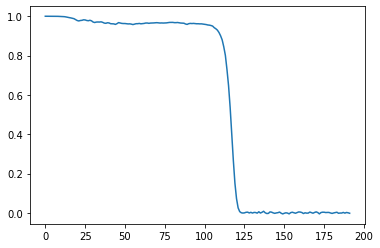

In [100]:
fsc_1d = comp_fsc(v_f1,v_f2)
pd.Series(fsc_1d).plot()

## mFSC
The modified FSC does the correlation in real space, piece by piece. Where each piece is the Fourier component of a shell, inverse FT-ed into real space, with the window applied after the iFT, but before doing the correlations. 
It makes perfect sense to apply the mask after the fact of computing the shells, since the whole maps is a sum of the shell pieces (the FT is linear) and we don't want to see how the noise outside the real space pieces is correlating
* See eq 6 in Penceck (2020)
$\text{mFSC} = \frac{\big|m\big[\widehat{[W(s)U]}\widehat{[W(s)V]}\big]\big|}{\big|m\big[\widehat{[W(s)U\big]}\big|\big|m\big[\widehat{[W(s)V\big]}\big|}$
  * m is a masking operator
  * W is a window (ie shell) operator, which can be Gaussian smoothed
  * $\widehat{[.]}$ is an inverse FT
  * U and V are FT of the halfmaps




In [98]:
sphere = np.linalg.norm(make_coordinates(nx,3),axis=1).reshape(nx,nx,nx) 
mask_sphere = sphere < .7*nx/2

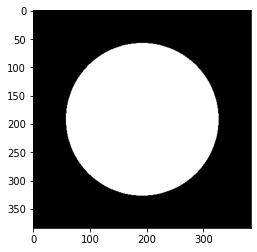

In [103]:
twod.do_2dplot(mask_sphere[nx//2])

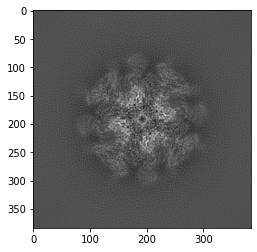

In [104]:
twod.do_2dplot(vol.mean(2))

In [109]:
shell_rad=1
rad_width=40
mask_shell = np.logical_and(shell_rad <= sphere,sphere < shell_rad+rad_width)

w_v_f1 = v_f1.copy()
w_v_f1[~mask_shell] = 0
w_v_r1 = fourier.do_ifft(w_v_f1, only_real=True) # maybe allow imag parts?

w_v_f2 = v_f2.copy()
w_v_f2[~mask_shell] = 0
w_v_r2 = fourier.do_ifft(w_v_f2, only_real=True)

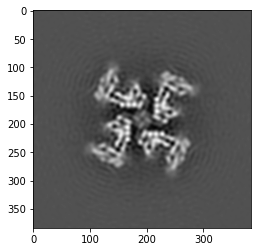

In [110]:
twod.do_2dplot(w_v_r1[:,:,nx//2])

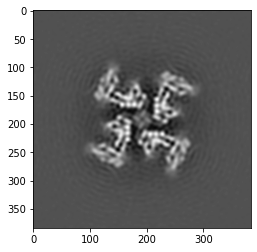

In [111]:
twod.do_2dplot(w_v_r2[:,:,nx//2])

The mFSC is computing correlations of these maps in real space (but masking out the solvent noise with the mask)

In [112]:
up = np.multiply(w_v_r1[mask_sphere],w_v_r2[mask_sphere]).sum()
down1 = np.linalg.norm(w_v_r1[mask_sphere])
down2 = np.linalg.norm(w_v_r2[mask_sphere])
mfsc = up / down1 / down2
mfsc

0.9951019369374887

In [115]:
%%time

def comp_mfsc(v_f1,v_f2,mask,shell_rad=1):
  '''
  TODO: parellalize the loop with iFFTs
  TODO: benchmark complex https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
  '''

  nx = v_f1.shape[0]
  sphere = np.linalg.norm(make_coordinates(nx,3),axis=1).reshape(nx,nx,nx)
  mfsc_1d = np.zeros(nx//2)

  for shell_rad in range(nx//2): # loop has two iffts
    mask_shell = np.logical_and(shell_rad <= sphere,sphere < shell_rad+rad_width)

    w_v_f1 = v_f1.copy()
    w_v_f1[~mask_shell] = 0
    w_v_r1 = fourier.do_ifft(w_v_f1, only_real=True) # maybe allow imag parts?

    w_v_f2 = v_f2.copy()
    w_v_f2[~mask_shell] = 0
    w_v_r2 = fourier.do_ifft(w_v_f2, only_real=True)

    up = np.multiply(w_v_r1[mask],w_v_r2[mask]).sum() # apply mask to both half maps so correlate less terms
    down1 = np.linalg.norm(w_v_r1[mask])
    down2 = np.linalg.norm(w_v_r2[mask])
    mfsc = up / down1 / down2
    mfsc_1d[shell_rad] = mfsc

  return(mfsc_1d)

mfsc_1d = comp_mfsc(v_f1,v_f2,mask_sphere,shell_rad=1)

CPU times: user 36min 25s, sys: 1min 29s, total: 37min 54s
Wall time: 36min 9s


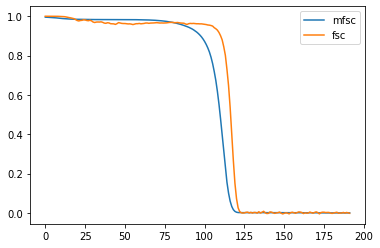

In [117]:
pd.Series(mfsc_1d).plot(legend=True,label='mfsc')
pd.Series(fsc_1d).plot(legend=True,label='fsc')

## Interpretation of finite window (shell) thickness
* The window (shell) operator, when it has a Gaussian edge, can be expressed as elementwise multiplication with $f(k,K,\sigma) = \exp[\frac{-(k-K)^2}{2\sigma^2}]$. We take the iFT, and by the convolution theorem, $\widehat{WU} = w*u$, where $w,u$ are the iFTs of $W,U$. But what what is $w$, and how exactly does it depend on $K,\sigma$? 

Eq. 5 in Henning et al. (2015) express the 3D FT with spherical coordinates, and integrate out the angular dependencies. Starting from eq. 5, we can do the integral, drawing on the resources 
  * https://math.stackexchange.com/questions/540292/gauss-integral-with-sine
  * https://math.stackexchange.com/questions/712434/erfaib-error-function-separate-into-real-and-imaginary-part (not needed, but informative)
  * https://ccrma.stanford.edu/~jos/sasp/Gaussian_Integral_Complex_Offset.html
  * https://mathworld.wolfram.com/GaussianIntegral.html
  * https://math.stackexchange.com/questions/712434/erfaib-error-function-separate-into-real-and-imaginary-part
  * https://en.wikipedia.org/wiki/Error_function
  * looking up integrals on Wolfram, [here](https://www.wolframalpha.com/input/?i=int+0+to+inf+x+exp%28-%28x-X%29%5E2%2Bi*a*x%29)

$$
w(r) = \int d^3\vec{k} \ f(k)e^{+i\vec{k} \cdot \vec{r}} \\
= 4\pi/r \int dk \ k f(k) \sin(rk) \\
= 4\pi/r \int dk \ k f(k) \Im{e^{irk}}  \\
= \frac{\sqrt 2 \pi^{3/2}}{r} e^{-\sigma^2r^2/2}[g(k,R,\sigma)-g^*)]
$$
  * where $g(r,K,\sigma) = e^{i\sqrt 2 \sigma r}(\sigma r - i K/\sigma)(\text{erf}[\frac{\sigma r - iK/\sigma}{\sqrt 2}]+1])$, and $g-g^*$ can  perhaps be better simplified.


## local mFSC
We can modify the real space mask to act on local regions and compute the correlation there

# scratch